For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction (showing which part of which series is responsible for a defect)
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score


In [2]:
np.random.seed(42)


In [3]:
n = 50000


In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base


In [6]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False False]


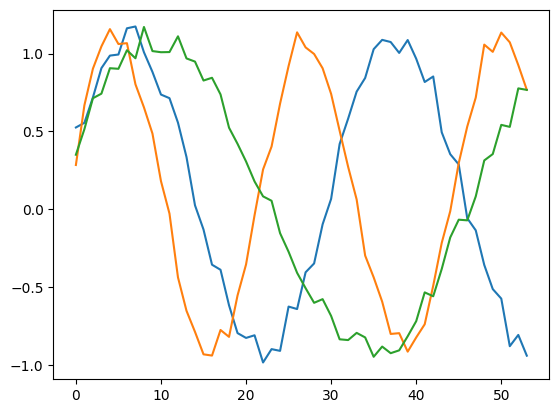

[False False  True False False]


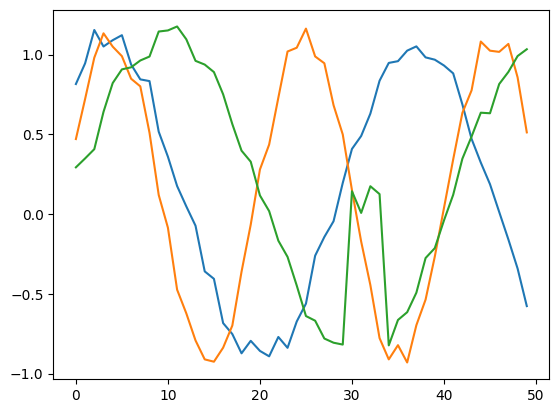

[False False False  True False]


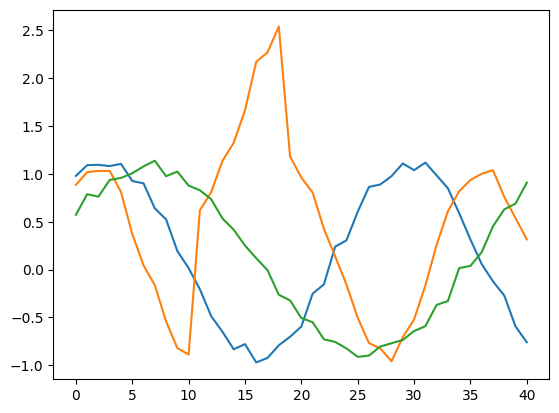

[False  True False False False]


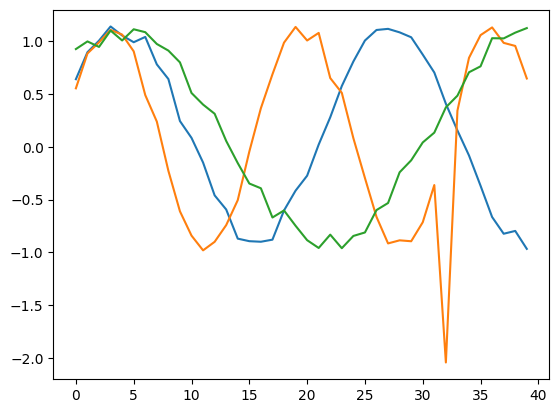

[ True False False False  True]


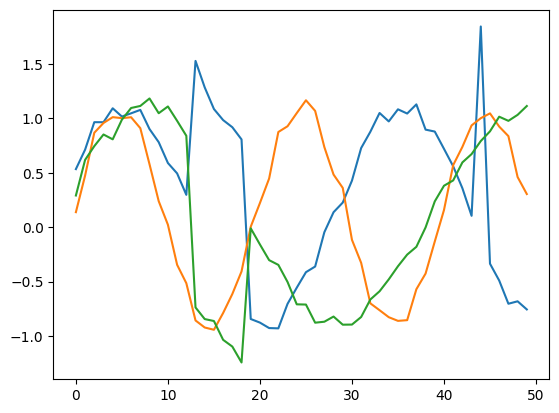

In [7]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()


The `pad_sequences` function pads sequences in `xl` to equal lengths with zeros at the end and converts them to `float32`, while `yl` is converted to a NumPy array for model compatibility.

In [8]:
from keras.preprocessing.sequence import pad_sequences

xl = pad_sequences(xl, dtype='float32', padding='post')
yl = np.array(yl)


The code splits the data into training, validation, and test sets based on specified fractions, ensuring each set contains the corresponding portions of `xl` and `yl`.

In [26]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

train_size = int(n*train_frac)
val_size = int(n*val_frac)

# Split the data
x_train, y_train = xl[:train_size], yl[:train_size]
x_val, y_val = xl[train_size:train_size + val_size], yl[train_size:train_size + val_size]
x_test, y_test = xl[train_size + val_size:], yl[train_size + val_size:]

In [11]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping

This LSTM-based sequential model processes time-series data with two LSTM layers (64 and 32 units), followed by a Dense layer with 5 sigmoid outputs for multi-label classification. It uses the Adam optimizer and binary cross-entropy loss for training.

In [12]:
seqLen = len(xl[0])
featNum = len(xl[0][0])

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seqLen, featNum)))
model.add(LSTM(32))
model.add(Dense(5, activation='sigmoid'))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 59, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,989 (117.14 KB)

 Trainable params: 29,989 (117.14 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# early = EarlyStopping(patience=7, restore_best_weights=True)
# model.fit(x_train,y_train, batch_size=64, epochs=50, validation_data=[x_val, y_val], callbacks=[early])

In [15]:
import keras
# model.save("RNN_model.keras")
model = keras.models.load_model("RNN_model.keras")

In [16]:
model.evaluate(x_test, y_test)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5503 - loss: 0.0089


[0.008212730288505554, 0.5604000091552734]

It looks like accuracy is low  (about 0.55), but in order to measure the actual accuracy we need to perform one last step - binarize predictions.

In [17]:
# Get the predictions as probabilities
y_pred = model.predict(x_test)

# Binarize predictions (using a threshold of 0.5)
y_pred_binarized = (y_pred > 0.5).astype(int)

# Now compare to y_test to compute accuracy manually
accuracy = np.mean(y_pred_binarized == y_test)
print("Binarized Accuracy:", accuracy)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Binarized Accuracy: 0.99776


An accuracy of 0.99776 indicates that the model correctly predicted the presence or absence of defects in 99.776% of test cases after binarizing the probabilities with a threshold of 0.5. This suggests the model performs exceptionally well on the test data and implies that there is no need to perfrom futher tests on different architectures, parameters etc.

Below there is short analysis of a one particular reading (x)

[3.8718961e-05 9.9990004e-01 9.6685281e-03 6.8187487e-04 4.6075300e-05]
[0 1 0 0 0]
[False  True False False False]


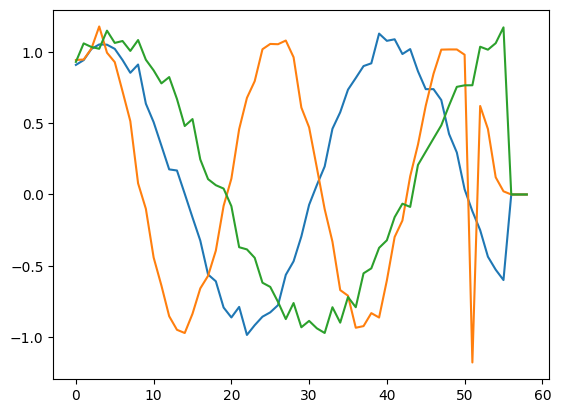

In [40]:
print(y_pred[179])
print(y_pred_binarized[179])
print(y_test[179])

plt.plot(x_test[179])

This model processes time-series data using two LSTM layers (64 and 32 units) to capture temporal patterns and outputs defect probabilities through a Dense layer with 5 sigmoid nodes, enabling multi-label classification. It is optimized with Adam and binary cross-entropy loss, making it well-suited for identifying multiple defects simultaneously.

In [126]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# https://stackoverflow.com/questions/47305618/what-is-the-role-of-timedistributed-layer-in-keras
def create_lstm_autoencoder(time_steps, features):
    inputs = Input(shape=(time_steps, features))
    
    encoded = LSTM(64, return_sequences=False)(inputs)
    encoded = RepeatVector(time_steps)(encoded)
    decoded = LSTM(64, return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(features))(decoded)
    
    autoencoder = Model(inputs, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = create_lstm_autoencoder(time_steps=59, features=3)
autoencoder.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 59, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 59, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 59, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 59, 3)          │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,627 (197.76 KB)

 Trainable params: 50,627 (197.76 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
# early = EarlyStopping(patience=7, restore_best_weights=True)

# history = autoencoder.fit(
#     x_train, x_train,
#     epochs=30,
#     steps_per_epoch=500,
#     batch_size=64,
#     validation_data=(x_val, x_val),
#     verbose=1
# )
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training & Validation Loss / Epochs')
# plt.legend()
# plt.show()

autoencoder = keras.models.load_model("RNN_model_predict_channels.keras")


In [128]:
autoencoder.save("RNN_model_predict_channels.keras")


In [129]:
reconstructed = autoencoder.predict(x_test)
reconstruction_error = (x_test - reconstructed) ** 2


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step


In [130]:
# Tested manually
anomalies = reconstruction_error > 0.05


Tested many thresholds manually - 0.05 performed well. This measures difference between reconstructed (estimatted) data and original.

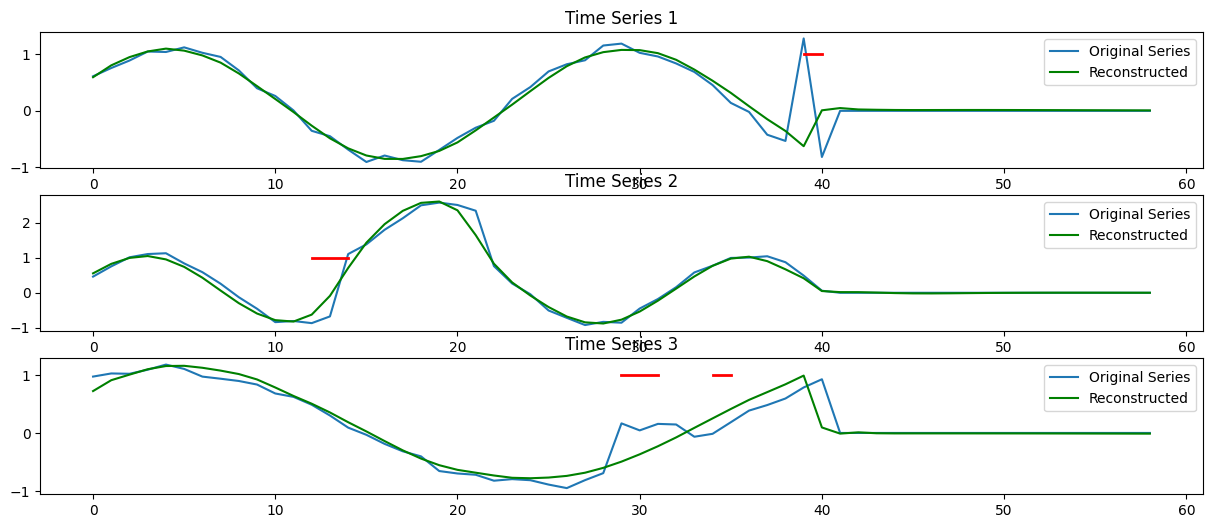

In [131]:
plt.figure(figsize=(15, 6))
n = 10
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(x_test[n, :, i], label='Original Series')
    plt.plot(reconstructed[n,:, i], 'g', label='Reconstructed')
    plt.legend()
    plt.plot(np.where(anomalies[n,:,i], 1, np.nan), 'r', label='Anomalies', linewidth=2)
    plt.title(f'Time Series {i+1}')
